# 1. Import Library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Extract Data

In [ ]:
df = pd.read_csv('/content/credit_risk_dataset.csv')
df.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


Source : https://www.kaggle.com/datasets/laotse/credit-risk-dataset/data

Feature's	Description :
1. person_age	: Age
2. person_income	: Annual Income
3. person_home_ownership	: Home ownership
4. person_emp_length :	Employment length (in years)
5. loan_intent :	Loan intent
6. loan_grade :	Loan grade
7. loan_amnt	: Loan amount
8. loan_int_rate :	Interest rate
9. loan_status :	Loan status (0 is non default 1 is default)
10. loan_percent_income :	Percent income
11. cb_person_default_on_file :	Historical default
12. cb_preson_cred_hist_length :	Credit history length

# 3. Mini EDA

In [ ]:
df['loan_status'].value_counts(normalize=True)

loan_status
0    0.781836
1    0.218164
Name: proportion, dtype: float64

<Axes: xlabel='loan_status'>

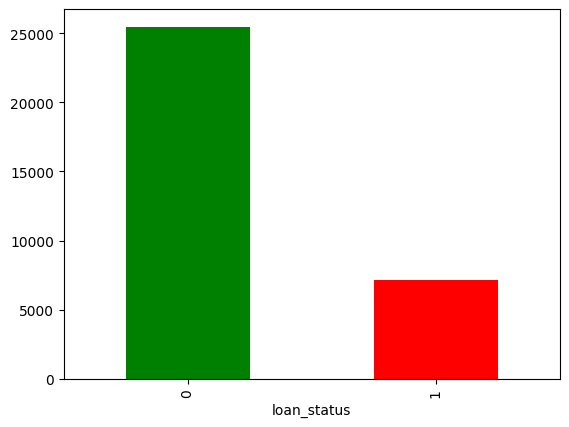

In [ ]:
df['loan_status'].value_counts().plot(kind='bar',color=['g','r'])

# 4. Data Splitting
Ingat : Splitting dulu baru balancing label di training only.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
df = df.dropna()

X = df.drop(columns=['loan_status'])
y = df['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42, stratify=y)

In [ ]:
y_train.value_counts(normalize=True)

loan_status
0    0.783413
1    0.216587
Name: proportion, dtype: float64

In [ ]:
y_test.value_counts(normalize=True)

loan_status
0    0.783345
1    0.216655
Name: proportion, dtype: float64

# 5. Balancing Label

In [ ]:
from imblearn.under_sampling import RandomUnderSampler # mengurangi label yang major
from imblearn.over_sampling import RandomOverSampler, SMOTE, SMOTENC, ADASYN  # menambahkan data yang minor

In [ ]:
# SMOTENC : SMOTE untuk data numerik + kategorik

oversampler = SMOTENC(categorical_features=[2,4,5,9], sampling_strategy='auto', random_state=42)
X_train_smotenc,y_train_smotenc = oversampler.fit_resample(X_train,y_train)

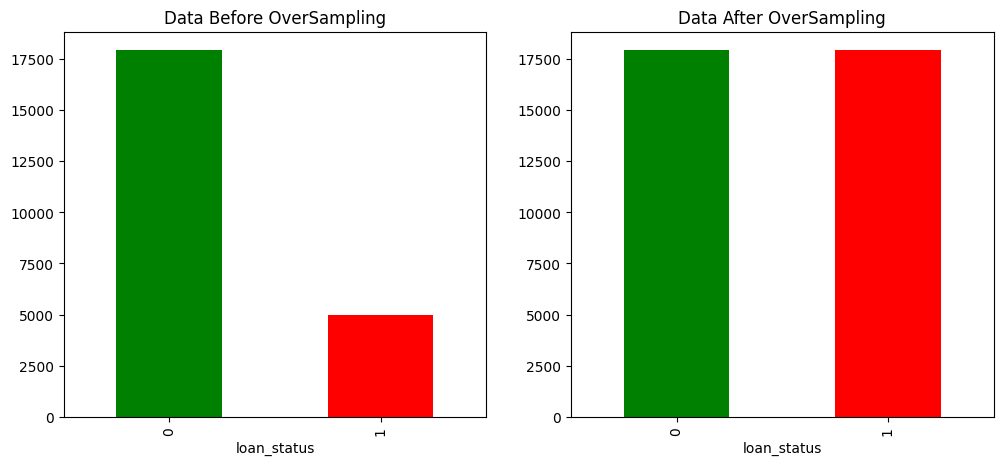

In [ ]:
# Visualisai Hasil SMOTENC
plt.figure(figsize=(12,5))
plt.subplot(121)
y_train.value_counts().plot(kind='bar',color=['g','r'])
plt.title("Data Before OverSampling");
plt.subplot(122)
y_train_smotenc.value_counts().plot(kind='bar',color=['g','r'])
plt.title("Data After OverSampling");

# 5. Pipeline

In [ ]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, RobustScaler, PowerTransformer
from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline
from sklearn.compose import  ColumnTransformer

from sklearn.svm import SVC
from xgboost import XGBClassifier

In [ ]:
num_preprocessor = Pipeline([("num_imputer", SimpleImputer(strategy='mean')),
                             ("num_scaler", PowerTransformer())])

cat_preprocessor = Pipeline([("cat_imputer", SimpleImputer(strategy='most_frequent')),
                             ("cat_onehot", OneHotEncoder())])


num_columns = X_train.select_dtypes(include=np.number).columns
cat_columns = X_train.select_dtypes(exclude=np.number).columns

preprocess = ColumnTransformer([("num_pipe", num_preprocessor, num_columns),
                                ("cat_pipe", cat_preprocessor, cat_columns)])

complete_pipeline = Pipeline([("preprocess_pipe",preprocess),
                              ("model", XGBClassifier(random_state=42))])

# 6. Training Model

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report

parameter = {
    'model__estimators' : [100,200],
    'model__max_depth' : [2,3,4]
}

model_rscv = RandomizedSearchCV(complete_pipeline, parameter, cv=5,verbose=1,n_jobs=-1, random_state=42)


def classification_model_performance(model,X,y,label="Training"):
    print("Model Performance in Data",label)
    y_pred = model.predict(X)
    print(classification_report(y,y_pred))

In [ ]:
def classification_model_performance(model,X,y,label="Training"):
    print("Model Performance in Data",label)
    y_pred = model.predict(X)
    print(classification_report(y,y_pred))

## 6.1. Unbalance Label

In [ ]:
model_rscv = model_rscv.fit(X_train,y_train)
model_rscv.best_params_

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 6 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [14:28:48] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "estimators" } are not used.

  warnings.warn(smsg, UserWarning)


{'model__max_depth': 4, 'model__estimators': 100}

In [ ]:
classification_model_performance(model_rscv,X_train,y_train,"Training")
classification_model_performance(model_rscv,X_test,y_test,"Testing")

Model Performance in Data Training
              precision    recall  f1-score   support

           0       0.93      1.00      0.96     17948
           1       0.98      0.75      0.85      4962

    accuracy                           0.94     22910
   macro avg       0.96      0.87      0.91     22910
weighted avg       0.94      0.94      0.94     22910

Model Performance in Data Testing
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      4487
           1       0.97      0.71      0.82      1241

    accuracy                           0.93      5728
   macro avg       0.95      0.85      0.89      5728
weighted avg       0.94      0.93      0.93      5728



## 6.2. Balanced Label

In [ ]:
model_rscv_balanced = model_rscv.fit(X_train_smotenc,y_train_smotenc)
model_rscv_balanced.best_params_

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 6 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [14:31:17] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "estimators" } are not used.

  warnings.warn(smsg, UserWarning)


{'model__max_depth': 4, 'model__estimators': 100}

In [ ]:
classification_model_performance(model_rscv_balanced,X_train_smotenc,y_train_smotenc,"Training")
classification_model_performance(model_rscv_balanced,X_test,y_test,"Testing")

Model Performance in Data Training
              precision    recall  f1-score   support

           0       0.93      0.98      0.95     17948
           1       0.98      0.92      0.95     17948

    accuracy                           0.95     35896
   macro avg       0.96      0.95      0.95     35896
weighted avg       0.96      0.95      0.95     35896

Model Performance in Data Testing
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      4487
           1       0.90      0.73      0.81      1241

    accuracy                           0.92      5728
   macro avg       0.91      0.85      0.88      5728
weighted avg       0.92      0.92      0.92      5728

